In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
shap.initjs()

In [2]:
data = pd.read_csv('/content/marketing_campaign.csv',delimiter='\t')

In [3]:
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


In [4]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

In [5]:
data.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

In [6]:
data.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
dtype: int64

In [7]:
data = data[data['Income'].notnull()]
data.reset_index(drop=True, inplace=True)

In [8]:
data['Year'] = data['Dt_Customer'].apply(lambda row: row.year)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
data['Age'] = data['Year'] - data['Year_Birth']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
vis_data = data.copy()
vis_data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Year,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,2012,55
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,2014,60
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,2013,48
3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,2014,30
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,2014,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,2013,46
2212,4001,1946,PhD,Together,64014.0,2,1,2014-10-06,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,2014,68
2213,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,2014,33
2214,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,2014,58


In [11]:
vis_data.drop([
    'ID',
    'Year_Birth',
    'Education',
    'Marital_Status',
    'Dt_Customer',
    'Year'
],axis=1, inplace=True)

vis_data.rename({
    'MntWines': 'WineRank',
    'MntFruits': 'FruitsRank',
    'MntMeatProducts': 'MeatRank',
    'MntFishProducts': 'FishRank',
    'MntSweetProducts': 'SweetRank',
    'MntGoldProds': 'GoldRank',
    'NumWebPurchases': 'WebRank',
    'NumCatalogPurchases': 'CatalogRank',
    'NumStorePurchases': 'StoreRank'
}, axis=1, inplace=True)

vis_data

,Income,Kidhome,Teenhome,Recency,WineRank,FruitsRank,MeatRank,FishRank,SweetRank,GoldRank,NumDealsPurchases,WebRank,CatalogRank,StoreRank,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,55
1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60
2,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,48
3,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30
4,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,46
2212,64014.0,2,1,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,68
2213,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,33
2214,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,58


In [12]:
vis_data.drop(['Recency'], axis=1, inplace=True)
vis_data

,Income,Kidhome,Teenhome,WineRank,FruitsRank,MeatRank,FishRank,SweetRank,GoldRank,NumDealsPurchases,WebRank,CatalogRank,StoreRank,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,58138.0,0,0,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,55
1,46344.0,1,1,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60
2,71613.0,0,0,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,48
3,26646.0,1,0,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30
4,58293.0,1,0,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,61223.0,0,1,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,46
2212,64014.0,2,1,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,68
2213,56981.0,0,0,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,33
2214,69245.0,0,1,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,58


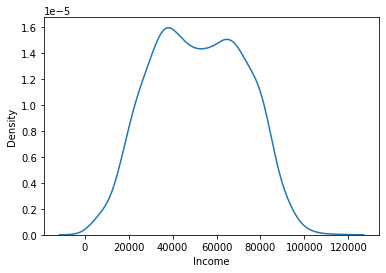

In [13]:
import seaborn as sns
outlier_idx = vis_data[vis_data['Income'] > 150000].index
vis_data.drop(outlier_idx, inplace=True)

sns.kdeplot(vis_data['Income'])

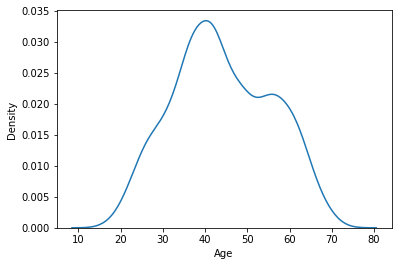

In [14]:
outlier_age = vis_data.loc[vis_data['Age'] > 90].index
vis_data.drop(outlier_age, inplace=True)
vis_data.reset_index(drop=True, inplace=True)

sns.kdeplot(vis_data['Age'])

In [15]:
vis_data['Kidhome'] = vis_data['Kidhome'].apply(lambda row: 1 if row >= 1 else 0)
vis_data['Teenhome'] = vis_data['Teenhome'].apply(lambda row: 1 if row >= 1 else 0)

vis_data

,Income,Kidhome,Teenhome,WineRank,FruitsRank,MeatRank,FishRank,SweetRank,GoldRank,NumDealsPurchases,WebRank,CatalogRank,StoreRank,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,58138.0,0,0,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,55
1,46344.0,1,1,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60
2,71613.0,0,0,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,48
3,26646.0,1,0,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30
4,58293.0,1,0,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,61223.0,0,1,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,46
2201,64014.0,1,1,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,68
2202,56981.0,0,0,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,33
2203,69245.0,0,1,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,58


In [16]:
from sklearn.preprocessing import StandardScaler

c_al_data = vis_data.copy()
main_data = vis_data.copy()
c_al_data

,Income,Kidhome,Teenhome,WineRank,FruitsRank,MeatRank,FishRank,SweetRank,GoldRank,NumDealsPurchases,WebRank,CatalogRank,StoreRank,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,58138.0,0,0,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,55
1,46344.0,1,1,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60
2,71613.0,0,0,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,48
3,26646.0,1,0,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30
4,58293.0,1,0,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,61223.0,0,1,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,46
2201,64014.0,1,1,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,68
2202,56981.0,0,0,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,33
2203,69245.0,0,1,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,58


In [17]:
num_col = ['Income', 'Age', 'NumDealsPurchases', 'NumWebVisitsMonth']
cat_col = ['Kidhome', 'Teenhome', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']

In [18]:
c_al_data['Accepted'] = c_al_data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis=1) > 0
c_al_data['Accepted'] = c_al_data['Accepted'].apply(lambda row: 1 if row else 0)

c_al_data.drop(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response'], axis=1, inplace=True)

c_al_data

,Income,Kidhome,Teenhome,WineRank,FruitsRank,MeatRank,FishRank,SweetRank,GoldRank,NumDealsPurchases,WebRank,CatalogRank,StoreRank,NumWebVisitsMonth,Complain,Age,Accepted
0,58138.0,0,0,635,88,546,172,88,88,3,8,10,4,7,0,55,1
1,46344.0,1,1,11,1,6,2,1,6,2,1,1,2,5,0,60,0
2,71613.0,0,0,426,49,127,111,21,42,1,8,2,10,4,0,48,0
3,26646.0,1,0,11,4,20,10,3,5,2,2,0,4,6,0,30,0
4,58293.0,1,0,173,43,118,46,27,15,5,5,3,6,5,0,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,61223.0,0,1,709,43,182,42,118,247,2,9,3,4,5,0,46,0
2201,64014.0,1,1,406,0,30,0,0,8,7,8,2,5,7,0,68,1
2202,56981.0,0,0,908,48,217,32,12,24,1,2,3,13,6,0,33,1
2203,69245.0,0,1,428,30,214,80,30,61,2,6,5,10,3,0,58,0


In [19]:
X = c_al_data.iloc[:, :-1]
y = c_al_data.iloc[:, -1]

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [21]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [22]:
y_pred = classifier.predict(X_test)

In [23]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [25]:
!pip install SHAP

In [31]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X)

#Rank Plot


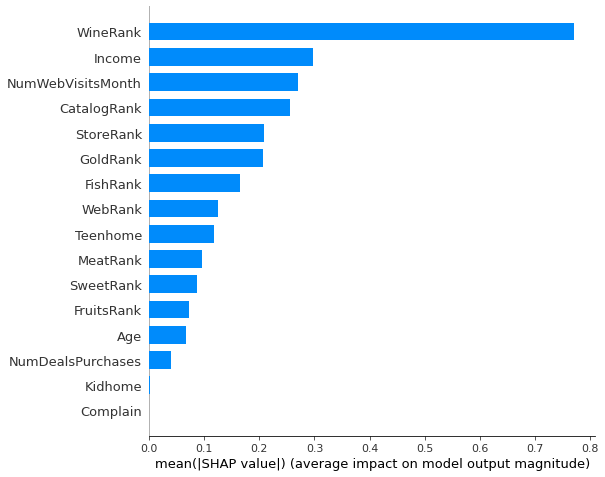

In [32]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

#Summary plot


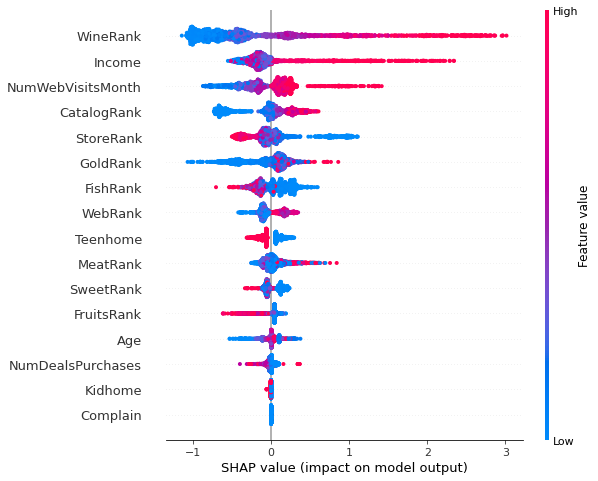

In [33]:
shap.summary_plot(shap_values, X)

#Individual Dependance plot


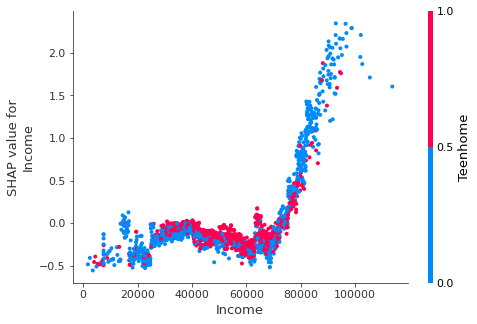

invalid value encountered in true_divide
invalid value encountered in true_divide


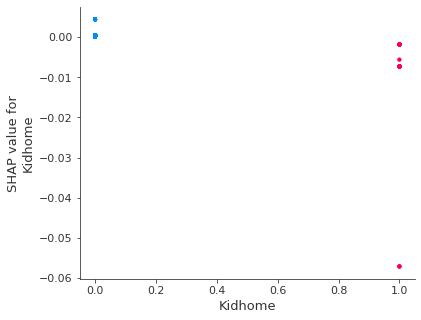

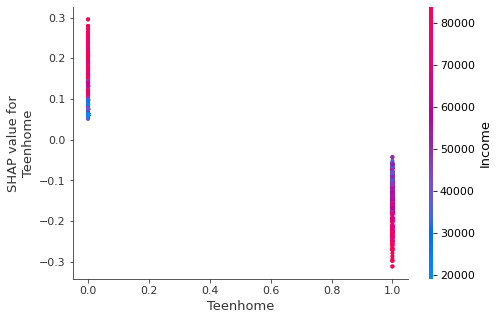

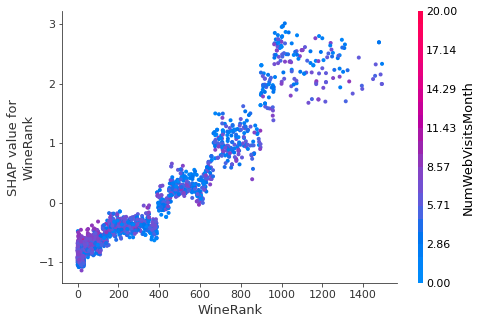

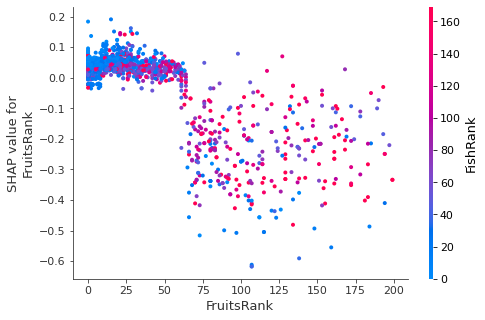

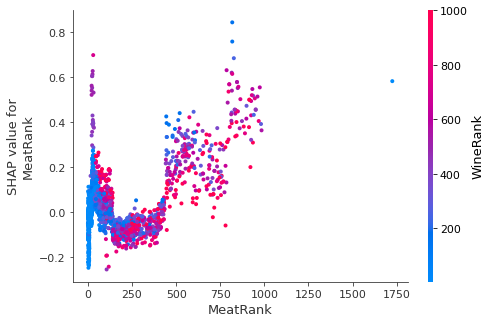

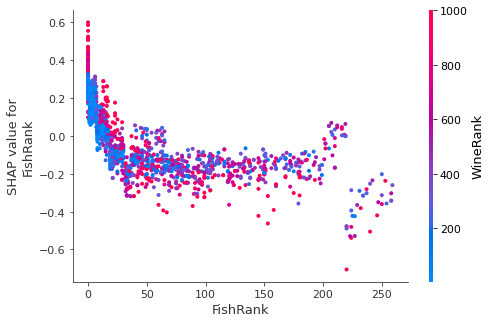

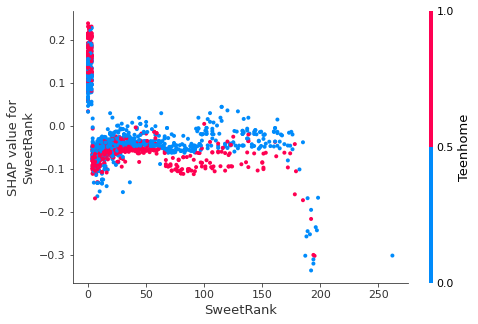

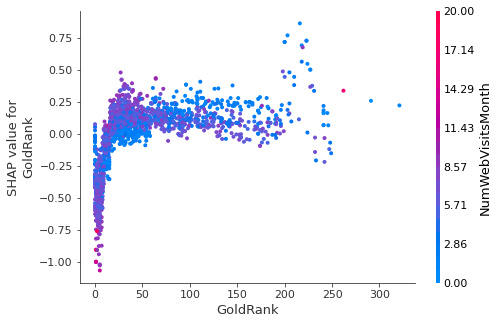

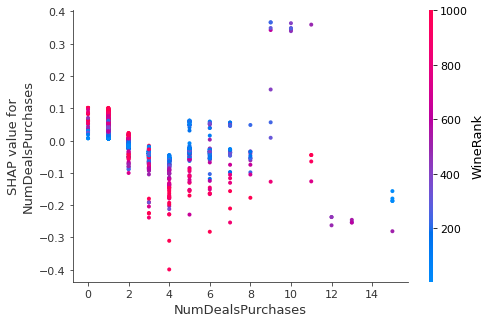

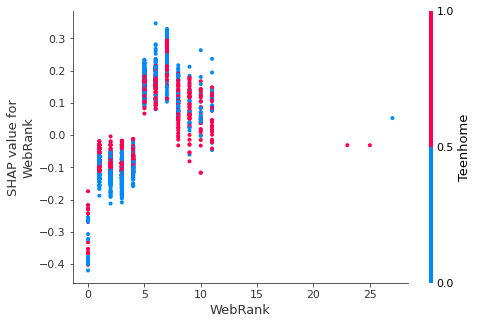

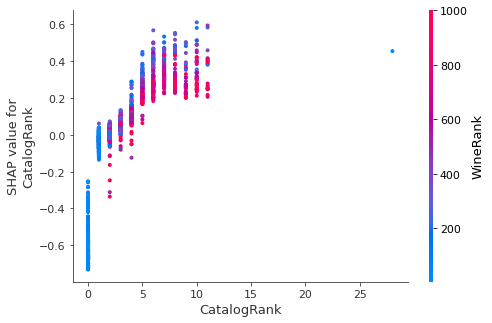

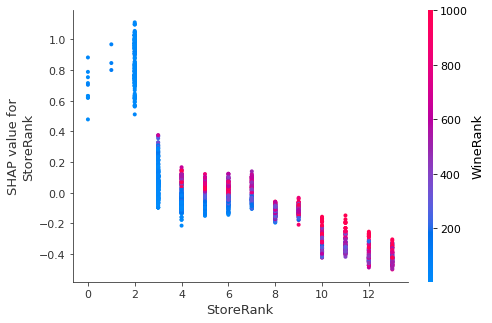

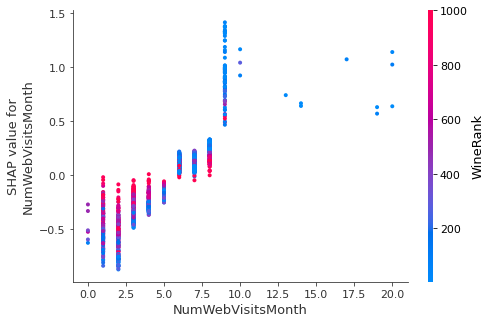

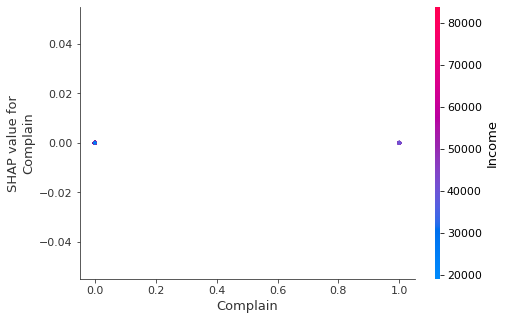

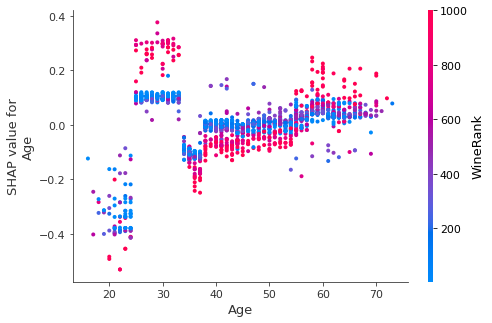

In [36]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)

MY RECOMMENDATIONS

*   From the Rank plot we can see that WineRank, Income are the major shreholders in the prediction of the results. So, the promotion team should look into these features more and try to make it more viable for the age group which has higher values for both.
*   We use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. We can see that Wine rank effects fewer prediction by large amount and all the other effect the values in smaller amount


*  I think targeting certain age groups will help to increase the chances of the person buying rather than making it available to a single age group. 





